<a href="https://colab.research.google.com/github/neha702/Face-mask-detector/blob/main/Face_mask_detector_(MobileNetV2_architecture).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [28]:
import cv2
from keras.models import Sequential
from keras.layers import Conv2D, Input,ZeroPadding2D, BatchNormalization, Activation, AveragePooling2D, Flatten, Dense,Dropout
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [29]:
train='/content/gdrive/MyDrive/face mask detection datasets/train'
test='/content/gdrive/MyDrive/face mask detection datasets/test'

In [51]:
train_data=ImageDataGenerator(rescale=1.0/255)
test_data=ImageDataGenerator(rescale=1.0/255)

In [52]:
train_generator = train_data.flow_from_directory(train, 
                                                    batch_size=50, 
                                                    target_size=(100, 100))
test_generator = test_data.flow_from_directory(test, 
                                                    batch_size=50, 
                                                    target_size=(100, 100))

Found 1315 images belonging to 2 classes.
Found 194 images belonging to 2 classes.


In [53]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(100, 100, 3)))
for layer in baseModel.layers:
    layer.trainable = False
model = Sequential()
model.add(baseModel)
model.add(Flatten())
model.add(Dense(2,activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
flatten_4 (Flatten)          (None, 20480)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 40962     
Total params: 2,298,946
Trainable params: 40,962
Non-trainable params: 2,257,984
_________________________________________________________________


In [56]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics ="accuracy")

In [57]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=len(train_generator),
                              epochs=10,
                              validation_data=test_generator,
                              validation_steps=len(test_generator))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
27/27 [==============================] - 14s 413ms/step - loss: 2.8306 - accuracy: 0.7512 - val_loss: 0.7375 - val_accuracy: 0.9485
Epoch 2/10
27/27 [==============================] - 10s 364ms/step - loss: 0.4357 - accuracy: 0.9571 - val_loss: 0.1124 - val_accuracy: 0.9794
Epoch 3/10
27/27 [==============================] - 10s 361ms/step - loss: 0.0542 - accuracy: 0.9908 - val_loss: 0.1496 - val_accuracy: 0.9897
Epoch 4/10
27/27 [==============================] - 10s 356ms/step - loss: 0.0137 - accuracy: 0.9975 - val_loss: 0.3679 - val_accuracy: 0.9691
Epoch 5/10
27/27 [==============================] - 10s 354ms/step - loss: 0.0299 - accuracy: 0.9968 - val_loss: 0.0907 - val_accuracy: 0.9845
Epoch 6/10
27/27 [==============================] - 10s 368ms/step - loss: 0.0126 - accuracy: 0.9991 - val_loss: 0.1163 - val_accuracy: 0.9742
Epoch 7/10
27/27 [==============================] - 10s 373ms/step - loss: 0.0246 - accuracy: 0.9986 - val_loss: 0.0870 - val_accuracy: 0.9794

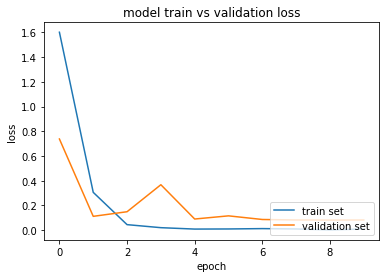

In [58]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='validation')
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(["train set", "validation set"], loc ="lower right") 
plt.show()

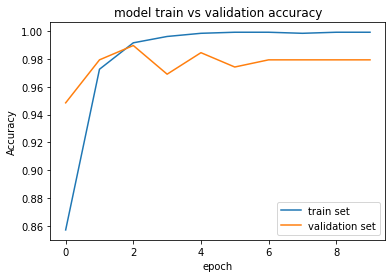

In [59]:
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='validation')
plt.title('model train vs validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(["train set", "validation set"], loc ="lower right") 
plt.show()

In [60]:
model.evaluate_generator(test_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.08292803913354874, 0.9793814420700073]

1

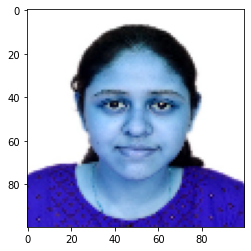

In [83]:
sample_mask_img = cv2.imread('/content/DSC_0450.jpg')
sample_mask_img = cv2.resize(sample_mask_img,(100,100))
plt.imshow(sample_mask_img)
sample_mask_img = np.reshape(sample_mask_img,[1,100,100,3])
sample_mask_img = sample_mask_img/255.0

result=model.predict(sample_mask_img)
label=np.argmax(result,axis=1)[0]
label

In [64]:
model.save('masknet.h5')

In [81]:
model=load_model("/content/masknet.h5")
haarcascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
results = {0:'MASK',1:'NO MASK'}
GR_dict = {0:(0,255,0),1:(255,0,0)}

In [84]:
#Face detector function
def face_mask_detector(img):
  faces=haarcascade.detectMultiScale(img)
  for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 3)
    face_img = img[y:y+h, x:x+w]
    rerect_sized=cv2.resize(face_img,(100,100))
    normalized=rerect_sized/255.0
    reshaped=np.reshape(normalized,(1,100,100,3))
    reshaped = np.vstack([reshaped])
    result=model.predict(reshaped)
    label=np.argmax(result,axis=1)[0]
      
    cv2.rectangle(img,(x,y),(x+w,y+h),GR_dict[label],2)
    cv2.rectangle(img,(x,y-40),(x+w,y),GR_dict[label],-1)
    cv2.putText(img, results[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,255,255),2)


    key = cv2.waitKey(10)
    
    if key == 27: 
     break

  

  cv2.destroyAllWindows()
  return img

In [85]:
from google.colab.patches import cv2_imshow

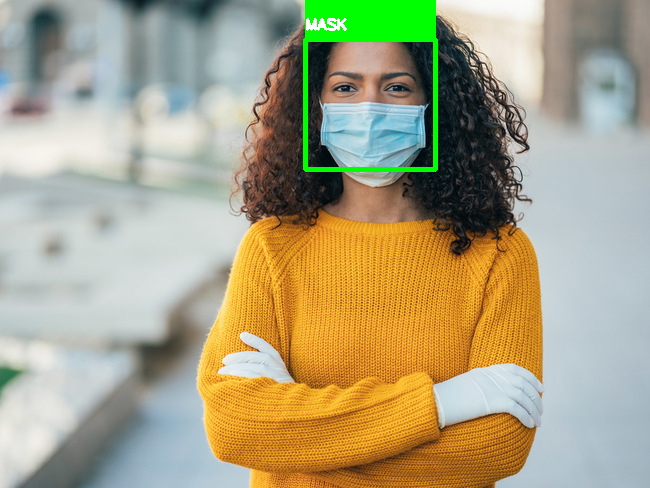

In [86]:
input_image = cv2.imread("/content/ss.jpg")
output = face_mask_detector(input_image)
cv2_imshow(output)

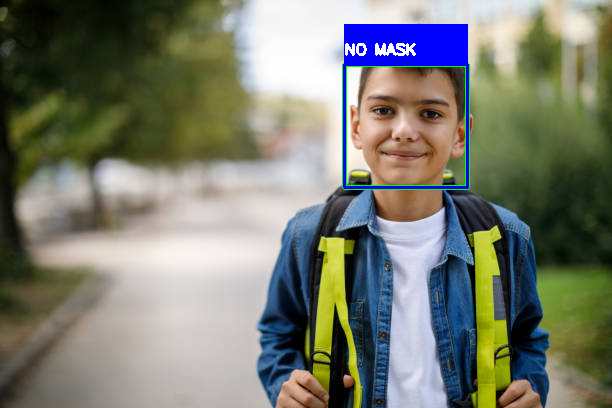

In [87]:
input_image = cv2.imread("/content/lil.jpg")
output = face_mask_detector(input_image)
cv2_imshow(output)

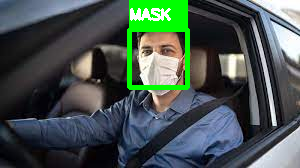

In [91]:
input_image = cv2.imread("/content/image_2021-04-19_034257.png")
output = face_mask_detector(input_image)
cv2_imshow(output)